## Get dataset from matminer datasets

In [1]:
#Import modules
from matminer.datasets import get_available_datasets
from matminer.featurizers.composition.element import ElementFraction
from matminer.datasets import get_all_dataset_info
from matminer.datasets.dataset_retrieval import load_dataset

In [2]:
get_available_datasets() #Get all information for available datasets in matminer
print(get_all_dataset_info("boltztrap_mp")) #get informationn for a specific dataset

boltztrap_mp: Effective mass and thermoelectric properties of 8924 compounds in The  Materials Project database that are calculated by the BoltzTraP software package run on the GGA-PBE or GGA+U density functional theory calculation results. The properties are reported at the temperature of 300 Kelvin and the carrier concentration of 1e18 1/cm3.

brgoch_superhard_training: 2574 materials used for training regressors that predict shear and bulk modulus.

castelli_perovskites: 18,928 perovskites generated with ABX combinatorics, calculating gllbsc band gap and pbe structure, and also reporting absolute band edge positions and heat of formation.

citrine_thermal_conductivity: Thermal conductivity of 872 compounds measured experimentally and retrieved from Citrine database from various references. The reported values are measured at various temperatures of which 295 are at room temperature.

dielectric_constant: 1,056 structures with dielectric properties, calculated with DFPT-PBE.

double_

In [3]:
ef = ElementFraction()
df = load_dataset("brgoch_superhard_training") #Load "brgoch_superhard_training" dataset
df = ef.featurize_dataframe(df, "composition") #Featurize "composition"
print('composition for Al is {}, composition for Pt is {} in AlPt3 '.format(df['Al'][0],df['Pt'][0])) #Get the composition of AlPt3

ElementFraction: 100%|██████████| 2574/2574 [00:02<00:00, 898.59it/s] 

composition for Al is 0.25, composition for Pt is 0.75 in AlPt3 


## Retrive dataset from materials project

In [24]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
mpdr = MPDataRetrieval("tqUlQrOc9T8stc6yWMK") #Or mpr = MPRester("your_api_key")
df = mpdr.get_dataframe(criteria={"nelements": 2}
                        ,properties=["pretty_formula","formation_energy_per_atom"] #Properties:https://github.com/materialsproject/mapidoc/tree/master/materials
                        , index_mpid=False
                       )

  0%|          | 0/19282 [00:00<?, ?it/s]

In [47]:
from matminer.featurizers.conversions import StrToComposition
df = df.rename(columns={"pretty_formula":"composition","formation_energy_per_atom":"formation_energy"})
data_raw = StrToComposition(target_col_id='composition_obj').featurize_dataframe(df, 'composition')

StrToComposition:   0%|          | 0/19282 [00:00<?, ?it/s]

In [48]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
feature_calculators = MultipleFeaturizer([cf.Stoichiometry()
                                          , cf.ElementProperty.from_preset("magpie")
                                          ,cf.ValenceOrbital(props=['avg'])
                                          , cf.IonProperty(fast=True)]
                                        ) #All features
feature_lables = feature_calculators.feature_labels() #Get labels of all generated features
data = data_raw
data = feature_calculators.featurize_dataframe(data, col_id='composition_obj')
data = data[feature_lables]

MultipleFeaturizer:   0%|          | 0/19282 [00:00<?, ?it/s]

In [52]:
from sklearn.decomposition import PCA 
explained_variance_ratio = []
for i in range(1,10): #Change n_components. Find an appropriate number of components that can represent most of the dataset and reduce computation time 
    pca = PCA(n_components=i)
    pca.fit(data)
    explained_variance_ratio.append(pca.explained_variance_ratio_.sum())

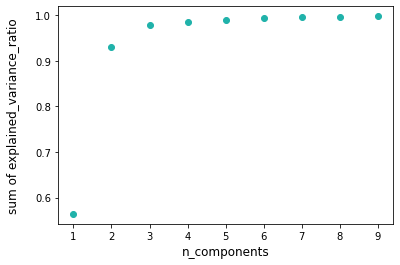

In [53]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots() #Plot the sum of explained_variance_ratio for different n_components
color = 'lightseagreen'
ax1.set_xlabel('n_components', fontsize=12)
ax1.set_ylabel('sum of explained_variance_ratio', fontsize=12, labelpad=15)
ax1.scatter(range(1,len(explained_variance_ratio)+1), explained_variance_ratio, color=color)
plt.show() #From the plot, 9 components can represent the dataset.

In [54]:
from sklearn.model_selection import train_test_split #Split dataset to test and train set
pca = PCA(n_components=9)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca.fit_transform(data), df["formation_energy"], test_size=0.3, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(data, df["formation_energy"], test_size=0.3, random_state=42)

In [55]:
from sklearn.linear_model import LinearRegression #Run the linear regression model to see the results
from sklearn.metrics import mean_squared_error
lr = LinearRegression().fit(X_train_pca,y_train_pca)
lr_ = LinearRegression().fit(X_train,y_train)
y_pred_pca = lr.predict(X_test_pca)
y_pred = lr_.predict(X_test)
print(mean_squared_error(y_test,y_pred))
print(mean_squared_error(y_test_pca,y_pred_pca))

0.21553607373823966
0.5367425563868605


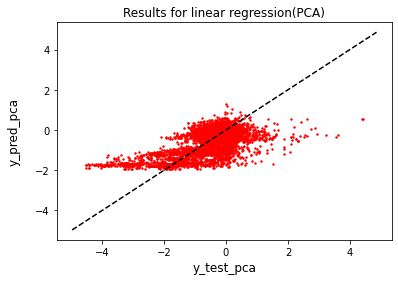

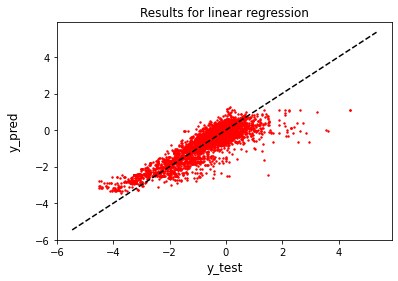

In [56]:
import matplotlib.pyplot as plt #Plot the results of linear regression
fig, ax1 = plt.subplots() #Plot y_pred and y_test
ax1.set_xlabel('y_test_pca', fontsize=12)
ax1.set_ylabel('y_pred_pca', fontsize=12, labelpad=15)
ax1.scatter(y_test_pca, y_pred_pca, color="red", s=2)
ax1.set_title("Results for linear regression(PCA)")
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--') #Dashed line shows y_pred == y_test

fig, ax2 = plt.subplots() #Plot y_pred and y_test
ax2.set_xlabel('y_test', fontsize=12)
ax2.set_ylabel('y_pred', fontsize=12, labelpad=15)
ax2.scatter(y_test, y_pred, color="red", s=2)
ax2.set_title("Results for linear regression")
ax2.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--') #Dashed line shows y_pred == y_test
plt.show()